In [8]:
import numpy as np
import pandas as pd
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras import utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
img_size = 224

In [3]:
df_data = pd.read_csv("archive/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [4]:
df_data[df_data.M==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg
14,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",16_right.jpg
16,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",18_right.jpg
29,35,68,Female,35_left.jpg,35_right.jpg,pathological myopia,normal fundus,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",35_right.jpg
37,46,66,Male,46_left.jpg,46_right.jpg,moderate non proliferative retinopathy,pathological myopia,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",46_right.jpg


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [6]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

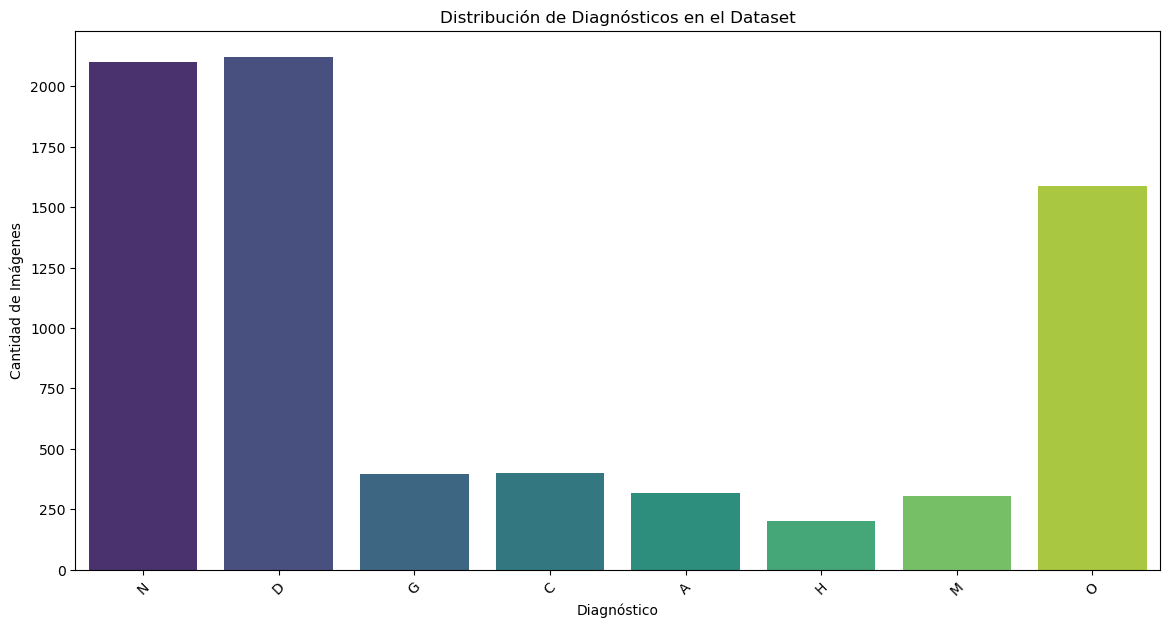

In [10]:
diagnosis_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
disease_counts = df_data[diagnosis_columns].sum()

plt.figure(figsize=(14, 7))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')
plt.title('Distribución de Diagnósticos en el Dataset')
plt.xlabel('Diagnóstico')
plt.ylabel('Cantidad de Imágenes')
plt.xticks(rotation=45)
plt.show()

C:\Users\luisu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


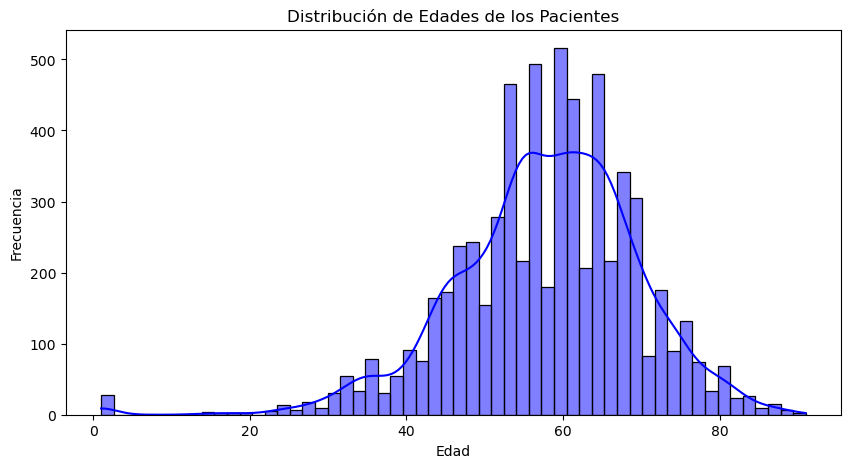

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df_data['Patient Age'], kde=True, color='blue')
plt.title('Distribución de Edades de los Pacientes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

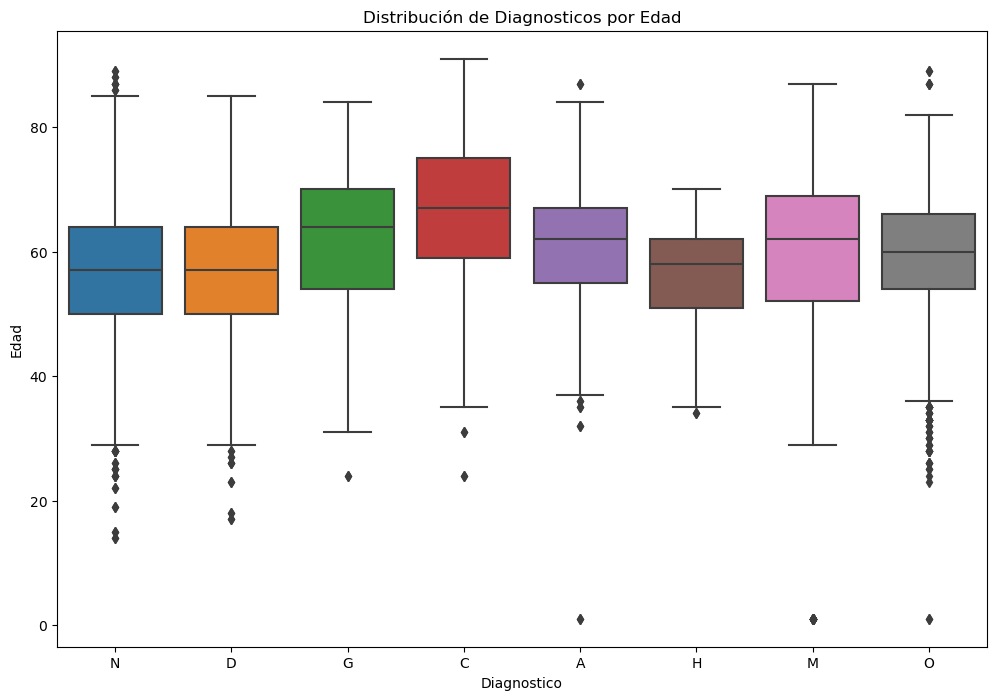

In [14]:
diagnosis_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'] 
data_long = df_data.melt(id_vars=['Patient Age'], value_vars=diagnosis_columns, var_name='diagnosis', value_name='presence')
data_long = data_long[data_long['presence'] == 1]
plt.figure(figsize=(12, 8))
sns.boxplot(x='diagnosis', y='Patient Age', data=data_long)
plt.title('Distribución de Diagnosticos por Edad')
plt.xlabel('Diagnostico')
plt.ylabel('Edad')
plt.show()

In [7]:
df_data2 = df_data.iloc[:, 1:7]
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [8]:
img_dir = "archive/preprocessed_images"

In [9]:
df_data2[df_data2['Left-Diagnostic Keywords'].str.match('pathological myopia')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
11,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia
16,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia
29,68,Female,35_left.jpg,35_right.jpg,pathological myopia,normal fundus
88,57,Female,106_left.jpg,106_right.jpg,pathological myopia,pathological myopia
122,49,Female,144_left.jpg,144_right.jpg,pathological myopia,normal fundus


In [10]:
df_left_myop = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('pathological myopia')]
print(len(df_left_myop))

208


In [11]:
df_data[df_data['Right-Diagnostic Keywords'].str.match('pathological myopia')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg
14,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",16_right.jpg
16,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",18_right.jpg
37,46,66,Male,46_left.jpg,46_right.jpg,moderate non proliferative retinopathy,pathological myopia,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",46_right.jpg
70,86,56,Female,86_left.jpg,86_right.jpg,mild nonproliferative retinopathy,pathological myopia,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",86_right.jpg


In [12]:
df_rt_myop = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('pathological myopia')]
print(len(df_rt_myop))

225


In [13]:
df_myop_filenames = df_left_myop['Left-Fundus']._append(df_rt_myop['Right-Fundus'], ignore_index=True)
df_myop_filenames.head()

0     13_left.jpg
1     18_left.jpg
2     35_left.jpg
3    106_left.jpg
4    144_left.jpg
dtype: object

In [14]:
df_myop_filenames.tail()

428    1666_right.jpg
429    1673_right.jpg
430    1681_right.jpg
431    1686_right.jpg
432    1694_right.jpg
dtype: object

In [15]:
len(df_myop_filenames)

433

(512, 512, 3)
525_right.jpg


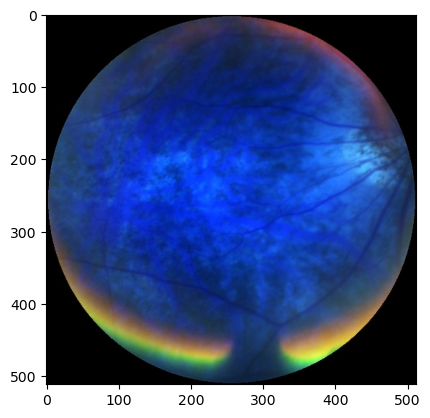

In [16]:
img = df_myop_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

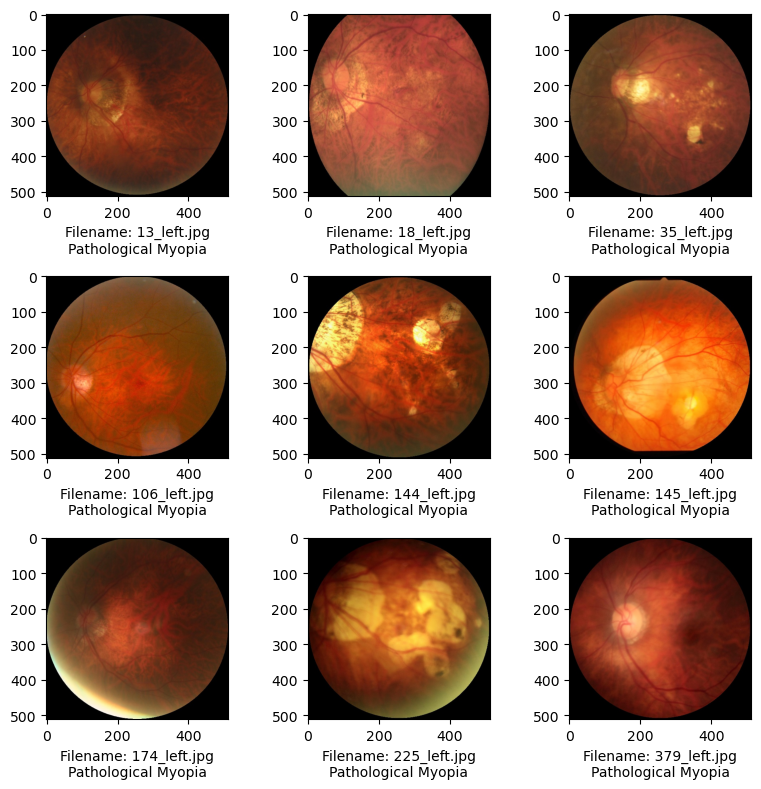

In [17]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_myop_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    plt.xlabel('Filename: {}\n''Pathological Myopia'.format(df_myop_filenames[i]))

plt.tight_layout()

In [18]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

In [19]:
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [20]:
df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [21]:
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


In [22]:
df_norm_filenames = df_left_norm['Left-Fundus']._append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

In [23]:
df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

4531    2360_right.jpg
983      3136_left.jpg
3267    2463_right.jpg
549      2649_left.jpg
95        437_left.jpg
dtype: object

In [24]:
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0      2360_right.jpg
1       3136_left.jpg
2      2463_right.jpg
3       2649_left.jpg
4        437_left.jpg
            ...      
567     3198_left.jpg
568    3366_right.jpg
569    2432_right.jpg
570     4387_left.jpg
571     2390_left.jpg
Length: 572, dtype: object

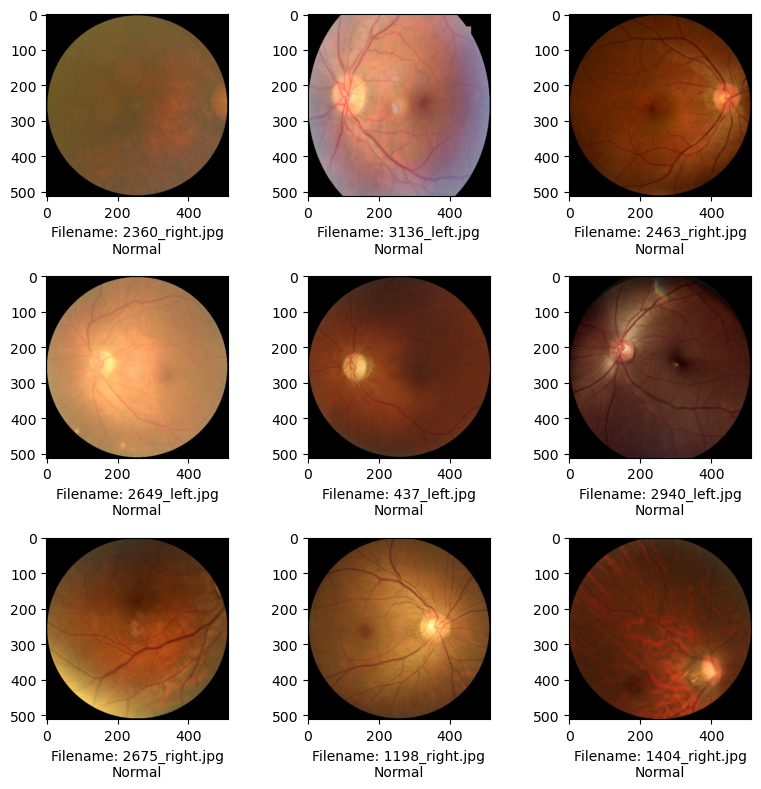

In [25]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)

    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

In [26]:
df_myop_filenames = pd.DataFrame(df_myop_filenames, columns = ["filename"])

df_myop_filenames["label"] = "pathological myopia"

df_myop_filenames.head()

,filename,label
0,13_left.jpg,pathological myopia
1,18_left.jpg,pathological myopia
2,35_left.jpg,pathological myopia
3,106_left.jpg,pathological myopia
4,144_left.jpg,pathological myopia


In [27]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])

df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,2360_right.jpg,normal
1,3136_left.jpg,normal
2,2463_right.jpg,normal
3,2649_left.jpg,normal
4,437_left.jpg,normal


In [28]:
df_combined = df_myop_filenames._append(df_norm_filenames_random, ignore_index=True)
df_combined

,filename,label
0,13_left.jpg,pathological myopia
1,18_left.jpg,pathological myopia
2,35_left.jpg,pathological myopia
3,106_left.jpg,pathological myopia
4,144_left.jpg,pathological myopia
...,...,...
1000,3198_left.jpg,normal
1001,3366_right.jpg,normal
1002,2432_right.jpg,normal
1003,4387_left.jpg,normal


In [29]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,1624_left.jpg,pathological myopia
1,3013_left.jpg,normal
2,351_right.jpg,normal
3,2381_right.jpg,normal
4,1572_right.jpg,pathological myopia
...,...,...
1000,1198_right.jpg,normal
1001,2612_right.jpg,normal
1002,2538_left.jpg,normal
1003,4163_right.jpg,normal


In [30]:
df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1005
804
201


In [31]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
            )

test_datagen=ImageDataGenerator(rescale=1./255.)

In [32]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [33]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 644 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Found 201 validated image filenames belonging to 2 classes.


In [34]:
train_image_data, train_labels = next(train_generator)
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

In [35]:
train_labels[0]

array([1., 0.], dtype=float32)

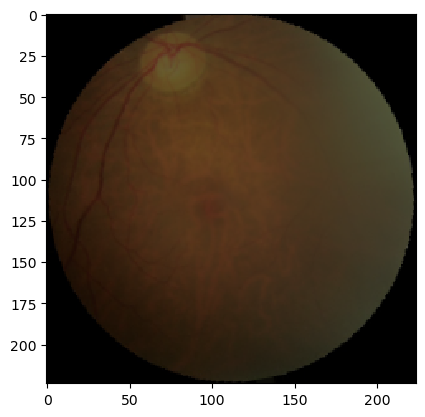

In [36]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

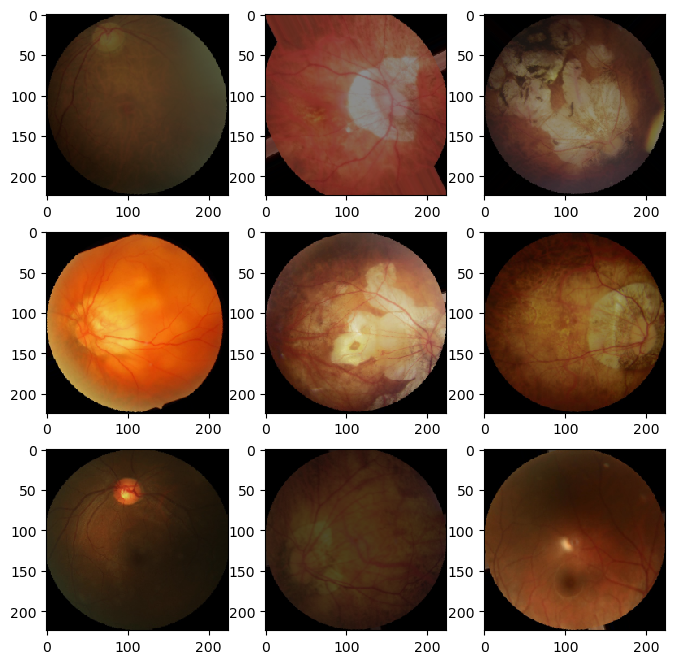

In [37]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show()

In [38]:
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

predictions = keras.layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
checkpoint = ModelCheckpoint("vgg16_1.h5.keras", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq="epoch")

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [40]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

20 5


In [41]:
hist = model.fit(train_generator,
                 steps_per_epoch=n_spe,
                 validation_data=valid_generator,
                 validation_steps=n_val_steps,
                 epochs=n_epochs,
                 shuffle=True,
                 callbacks=[checkpoint, early])

C:\Users\luisu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


C:\Users\luisu\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5685 - loss: 2.1577
Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to vgg16_1.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.5694 - loss: 2.1434 - val_accuracy: 0.8062 - val_loss: 0.6031
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6250 - loss: 1.0714 
Epoch 3/30


C:\Users\luisu\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
C:\Users\luisu\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\luisu\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6378 - loss: 0.8884
Epoch 3: val_accuracy improved from 0.80625 to 0.81875, saving model to vgg16_1.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.6395 - loss: 0.8860 - val_accuracy: 0.8188 - val_loss: 0.3988
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8750 - loss: 0.4183 
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7327 - loss: 0.6581
Epoch 5: val_accuracy did not improve from 0.81875
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7325 - loss: 0.6578 - val_accuracy: 0.6812 - val_loss: 0.6347
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5938 - loss: 0.9364 
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7375 - loss: 0.5979
Epoch 7: val_accuracy improved from 0.81875 to 0.88125, saving model to vgg16_1.h5.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.7378 - loss: 0.5959 - val_accuracy: 0.8813 - val_loss: 0.3093
Epoch 8/30
20/20 ━

In [42]:
# Guardar el modelo entrenado 
model.save('modelo_miopia_cnn.keras') 

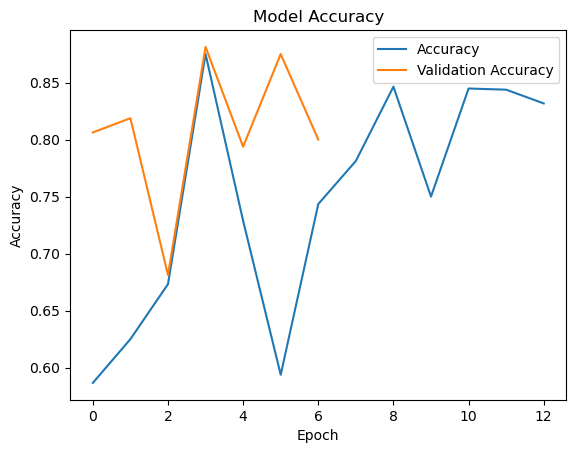

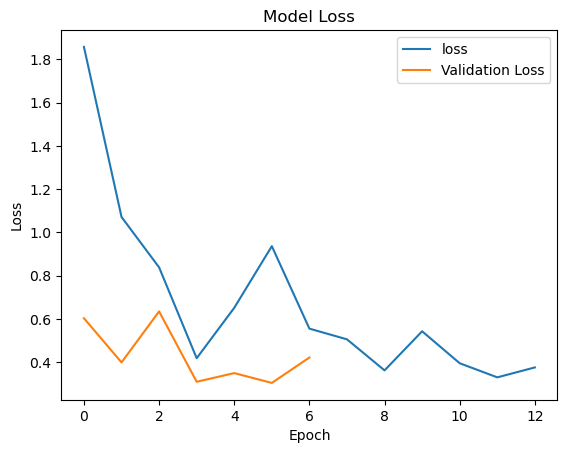

In [43]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [44]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9372 - loss: 0.1450
Pérdida en el conjunto de prueba: 0.1368200033903122
Precisión en el conjunto de prueba: 0.9452736377716064


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


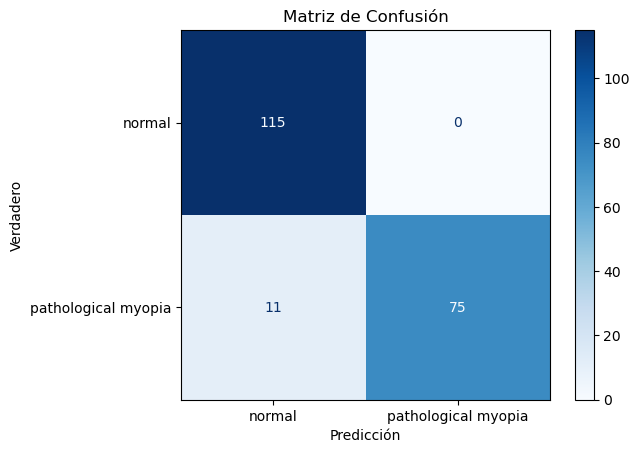

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       115
           1       1.00      0.87      0.93        86

    accuracy                           0.95       201
   macro avg       0.96      0.94      0.94       201
weighted avg       0.95      0.95      0.94       201



In [101]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generar predicciones en el conjunto de prueba
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Si la salida es categórica
y_true = test_generator.classes

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_classes)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()


# Reporte de Clasificación
print("Reporte de Clasificación:\n", classification_report(y_true, y_pred_classes))

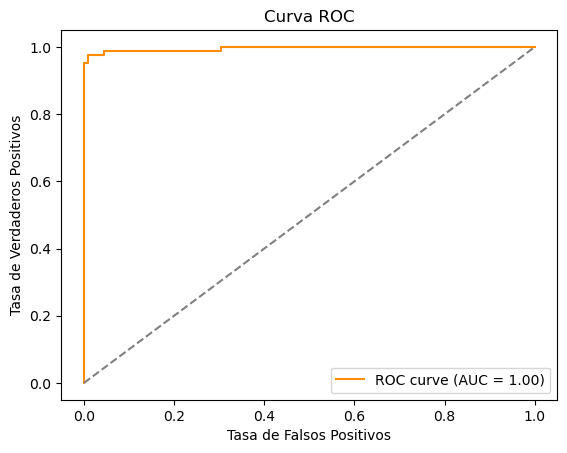

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  # Cambia el índice según tu clase positiva
roc_auc = auc(fpr, tpr)

# Gráfico de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

C:\Users\luisu\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


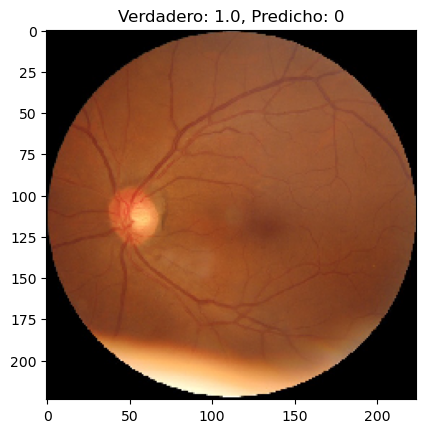

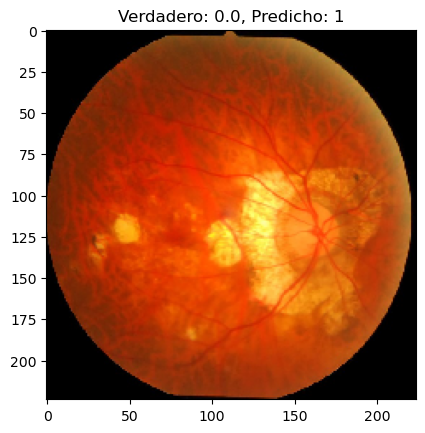

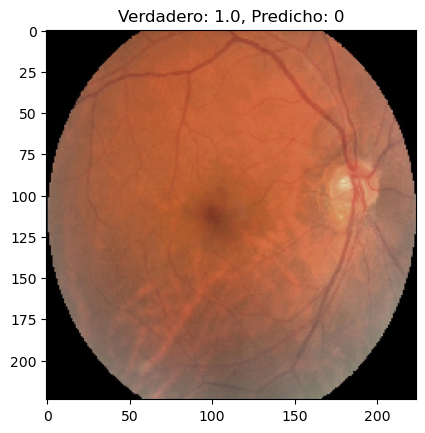

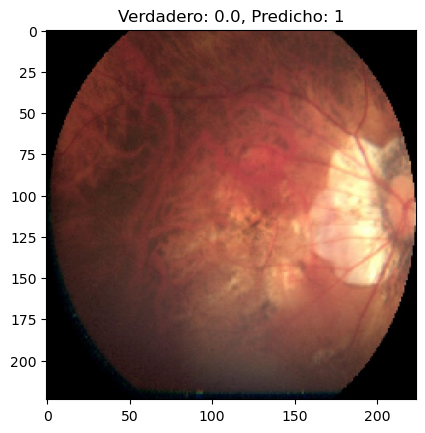

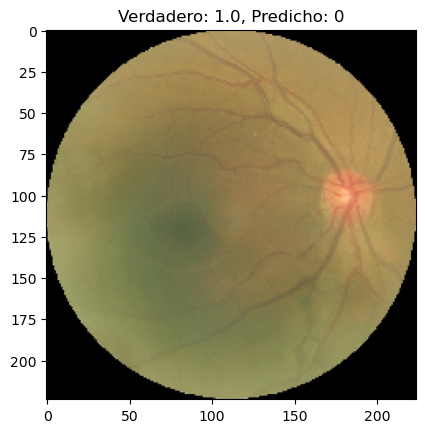

In [47]:
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

for img_batch, true_label_batch in test_generator:
    y_pred_batch = model.predict(img_batch)
    y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)

    for img, true_label, predicted_label in zip(img_batch, true_label_batch, y_pred_classes_batch):
        if true_label[0] != predicted_label: 
            misclassified_images.append(img)
            misclassified_true_labels.append(true_label[0])
            misclassified_predicted_labels.append(predicted_label)

    if len(misclassified_images) >= 5:  # Limitar a 5 ejemplos
        break

import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(misclassified_images[i])
    plt.title(f"Verdadero: {misclassified_true_labels[i]}, Predicho: {misclassified_predicted_labels[i]}")
    plt.show()
